# Quality Prediction - Classification
In this notebook, we will be exploring a machine learning approach to predict wine quality. We will be using a dataset that contains various properties of wines and their corresponding quality ratings for training and comparing the performances of various classification models.

In [2]:
import hopsworks
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from hsml.schema import Schema
from hsml.model_schema import ModelSchema
import joblib
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import os

## Accessing the Feature View
First we connect to Hopsworks to get access to our previously uploaded feature dataset.

In [3]:
project = hopsworks.login()
fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://35.204.254.42/p/119
Connected. Call `.close()` to terminate connection gracefully.


A feature view is then created to operate on our preprocessed wine dataset.

In [4]:
wine_fg = fs.get_feature_group(name="wine_reduced_new")
query = wine_fg.select_all()
feature_view = fs.get_or_create_feature_view(name="wine_reduced_new",
                                  version=1,
                                  description="Read from Wine dataset",
                                  labels=["quality"],
                                  query=query)

Feature view created successfully, explore it at 
https://35.204.254.42/p/119/fs/67/fv/wine_reduced_new/version/1


## Classification
First, we split our dataset into training and testing sets, with a ratio of 0.8 to 0.2.

In [5]:
X_train, X_test, y_train, y_test = feature_view.train_test_split(0.2)

Finished: Reading data from Hopsworks, using ArrowFlight (2.13s) 


### KNN
The forst model we tested is a KNearestNeighbors classifier, which is expected to give us a baseline performance measurement and additional insights into the dataset distribution.

In [6]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=2, weights='uniform')
model.fit(X_train, y_train.values.ravel())

KNeighborsClassifier(n_neighbors=2)

In [7]:
y_pred = model.predict(X_test)
metrics = classification_report(y_test, y_pred, output_dict=True)
results = confusion_matrix(y_test, y_pred)
metrics

{'3': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 9},
 '4': {'precision': 0.06896551724137931,
  'recall': 0.0851063829787234,
  'f1-score': 0.0761904761904762,
  'support': 47},
 '5': {'precision': 0.430062630480167,
  'recall': 0.555256064690027,
  'f1-score': 0.48470588235294115,
  'support': 371},
 '6': {'precision': 0.44731182795698926,
  'recall': 0.48148148148148145,
  'f1-score': 0.46376811594202894,
  'support': 432},
 '7': {'precision': 0.3392857142857143,
  'recall': 0.10555555555555556,
  'f1-score': 0.1610169491525424,
  'support': 180},
 '8': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 25},
 '9': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 2},
 'accuracy': 0.4099437148217636,
 'macro avg': {'precision': 0.18366081285203567,
  'recall': 0.1753427835293982,
  'f1-score': 0.16938306051971266,
  'support': 1066},
 'weighted avg': {'precision': 0.39128025653596127,
  'recall': 0.4099437148217636,
  'f1-score': 0.38718359443

As expected, scores and averaegs are not high: for the classes with the majority of samples, the model is able to reach acceptable performances, while the classes with fewer samples, like 3 and 9, are never scored accurately. Their scarcity suggests that possible approaches should focus on rebalancing the dataset classes.

In [8]:
df_cm = pd.DataFrame(results)
cm = sns.heatmap(df_cm, annot=True)
fig = cm.get_figure()

### Random Forest
Given that the relationships between features and the target variable are complex and nonlinear, we use Random Forest Classification as a model, in order to capture intricate patterns and interactions in the data. To determine the optimal parameters for the model, we can first perform some hyperparameter tuning via Grid Search.

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
}

classifier = RandomForestClassifier(random_state=42, class_weight='balanced')
grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=2, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train.ravel())
best_params = grid_search.best_params_

Fitting 2 folds for each of 36 candidates, totalling 72 fits


[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   0.6s


[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   0.6s


[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=   1.2s


[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=   1.2s


[CV] END max_depth=None, min_samples_split=2, n_estimators=300; total time=   1.9s


[CV] END max_depth=None, min_samples_split=2, n_estimators=300; total time=   1.7s


[CV] END max_depth=None, min_samples_split=5, n_estimators=100; total time=   0.6s


[CV] END max_depth=None, min_samples_split=5, n_estimators=100; total time=   0.6s


[CV] END max_depth=None, min_samples_split=5, n_estimators=200; total time=   1.1s


[CV] END max_depth=None, min_samples_split=5, n_estimators=200; total time=   1.1s


[CV] END max_depth=None, min_samples_split=5, n_estimators=300; total time=   1.7s


[CV] END max_depth=None, min_samples_split=5, n_estimators=300; total time=   1.7s


[CV] END max_depth=None, min_samples_split=10, n_estimators=100; total time=   0.6s


[CV] END max_depth=None, min_samples_split=10, n_estimators=100; total time=   0.5s


[CV] END max_depth=None, min_samples_split=10, n_estimators=200; total time=   1.1s


[CV] END max_depth=None, min_samples_split=10, n_estimators=200; total time=   1.0s


[CV] END max_depth=None, min_samples_split=10, n_estimators=300; total time=   1.6s


[CV] END max_depth=None, min_samples_split=10, n_estimators=300; total time=   1.7s


[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   0.5s


[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   0.6s


[CV] END max_depth=10, min_samples_split=2, n_estimators=200; total time=   1.0s


[CV] END max_depth=10, min_samples_split=2, n_estimators=200; total time=   1.0s


[CV] END max_depth=10, min_samples_split=2, n_estimators=300; total time=   1.4s


[CV] END max_depth=10, min_samples_split=2, n_estimators=300; total time=   1.4s


[CV] END max_depth=10, min_samples_split=5, n_estimators=100; total time=   0.5s


[CV] END max_depth=10, min_samples_split=5, n_estimators=100; total time=   0.5s


[CV] END max_depth=10, min_samples_split=5, n_estimators=200; total time=   0.9s


[CV] END max_depth=10, min_samples_split=5, n_estimators=200; total time=   1.0s


[CV] END max_depth=10, min_samples_split=5, n_estimators=300; total time=   1.4s


[CV] END max_depth=10, min_samples_split=5, n_estimators=300; total time=   1.4s


[CV] END max_depth=10, min_samples_split=10, n_estimators=100; total time=   0.5s


[CV] END max_depth=10, min_samples_split=10, n_estimators=100; total time=   0.5s


[CV] END max_depth=10, min_samples_split=10, n_estimators=200; total time=   0.9s


[CV] END max_depth=10, min_samples_split=10, n_estimators=200; total time=   0.9s


[CV] END max_depth=10, min_samples_split=10, n_estimators=300; total time=   1.3s


[CV] END max_depth=10, min_samples_split=10, n_estimators=300; total time=   1.3s


[CV] END max_depth=20, min_samples_split=2, n_estimators=100; total time=   0.6s


[CV] END max_depth=20, min_samples_split=2, n_estimators=100; total time=   0.6s


[CV] END max_depth=20, min_samples_split=2, n_estimators=200; total time=   1.2s


[CV] END max_depth=20, min_samples_split=2, n_estimators=200; total time=   1.2s


[CV] END max_depth=20, min_samples_split=2, n_estimators=300; total time=   1.8s


[CV] END max_depth=20, min_samples_split=2, n_estimators=300; total time=   1.7s


[CV] END max_depth=20, min_samples_split=5, n_estimators=100; total time=   0.6s


[CV] END max_depth=20, min_samples_split=5, n_estimators=100; total time=   0.6s


[CV] END max_depth=20, min_samples_split=5, n_estimators=200; total time=   1.1s


[CV] END max_depth=20, min_samples_split=5, n_estimators=200; total time=   1.1s


[CV] END max_depth=20, min_samples_split=5, n_estimators=300; total time=   1.8s


[CV] END max_depth=20, min_samples_split=5, n_estimators=300; total time=   1.7s


[CV] END max_depth=20, min_samples_split=10, n_estimators=100; total time=   0.5s


[CV] END max_depth=20, min_samples_split=10, n_estimators=100; total time=   0.5s


[CV] END max_depth=20, min_samples_split=10, n_estimators=200; total time=   1.1s


[CV] END max_depth=20, min_samples_split=10, n_estimators=200; total time=   1.2s


[CV] END max_depth=20, min_samples_split=10, n_estimators=300; total time=   1.7s


[CV] END max_depth=20, min_samples_split=10, n_estimators=300; total time=   1.6s


[CV] END max_depth=30, min_samples_split=2, n_estimators=100; total time=   0.6s


[CV] END max_depth=30, min_samples_split=2, n_estimators=100; total time=   0.6s


[CV] END max_depth=30, min_samples_split=2, n_estimators=200; total time=   1.2s


[CV] END max_depth=30, min_samples_split=2, n_estimators=200; total time=   1.2s


[CV] END max_depth=30, min_samples_split=2, n_estimators=300; total time=   1.8s


[CV] END max_depth=30, min_samples_split=2, n_estimators=300; total time=   1.8s


[CV] END max_depth=30, min_samples_split=5, n_estimators=100; total time=   0.6s


[CV] END max_depth=30, min_samples_split=5, n_estimators=100; total time=   0.6s


[CV] END max_depth=30, min_samples_split=5, n_estimators=200; total time=   1.2s


[CV] END max_depth=30, min_samples_split=5, n_estimators=200; total time=   1.1s


[CV] END max_depth=30, min_samples_split=5, n_estimators=300; total time=   1.7s


[CV] END max_depth=30, min_samples_split=5, n_estimators=300; total time=   1.7s


[CV] END max_depth=30, min_samples_split=10, n_estimators=100; total time=   0.5s


[CV] END max_depth=30, min_samples_split=10, n_estimators=100; total time=   0.5s


[CV] END max_depth=30, min_samples_split=10, n_estimators=200; total time=   1.1s


[CV] END max_depth=30, min_samples_split=10, n_estimators=200; total time=   1.1s


[CV] END max_depth=30, min_samples_split=10, n_estimators=300; total time=   1.6s


[CV] END max_depth=30, min_samples_split=10, n_estimators=300; total time=   1.6s


In [10]:
print(best_params)

{'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}


Class weights are also set to 'balanced' to take into account the information about the imbalanced classes. We can see that the scores for the Random Forest Classifier are more promising than KNN, but the model still struggles in predicting correctly the minority classes.

In [11]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_leaf=1, min_samples_split=2, random_state=50, class_weight = 'balanced')

classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         9
           4       0.29      0.04      0.07        47
           5       0.65      0.58      0.61       371
           6       0.51      0.74      0.60       432
           7       0.57      0.31      0.40       180
           8       0.25      0.04      0.07        25
           9       0.00      0.00      0.00         2

    accuracy                           0.56      1066
   macro avg       0.32      0.24      0.25      1066
weighted avg       0.55      0.56      0.53      1066



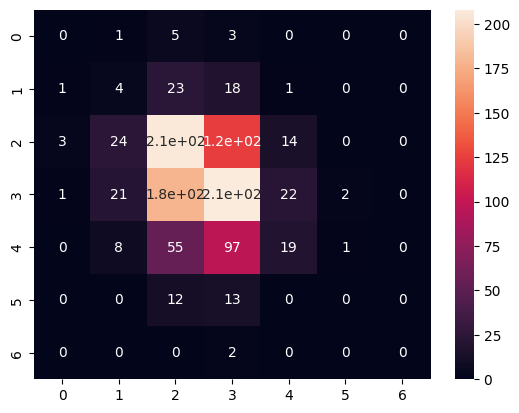

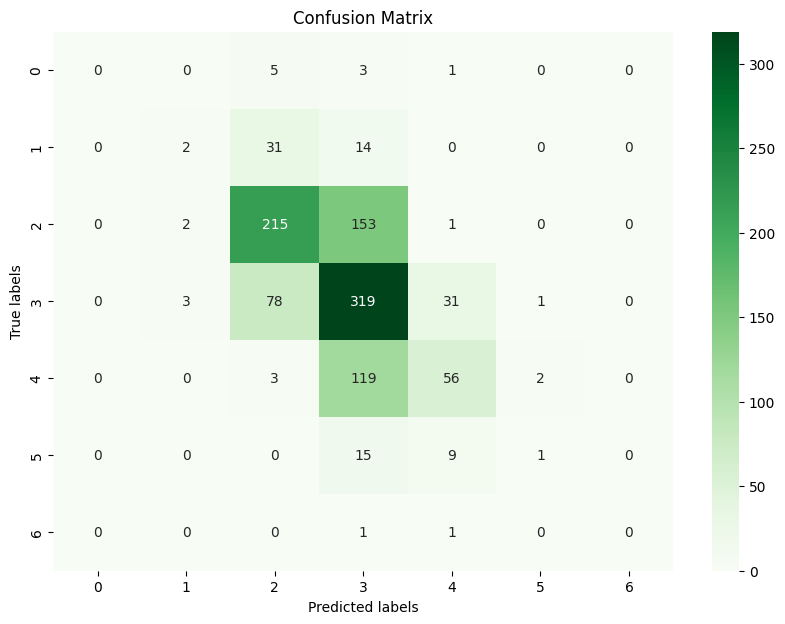

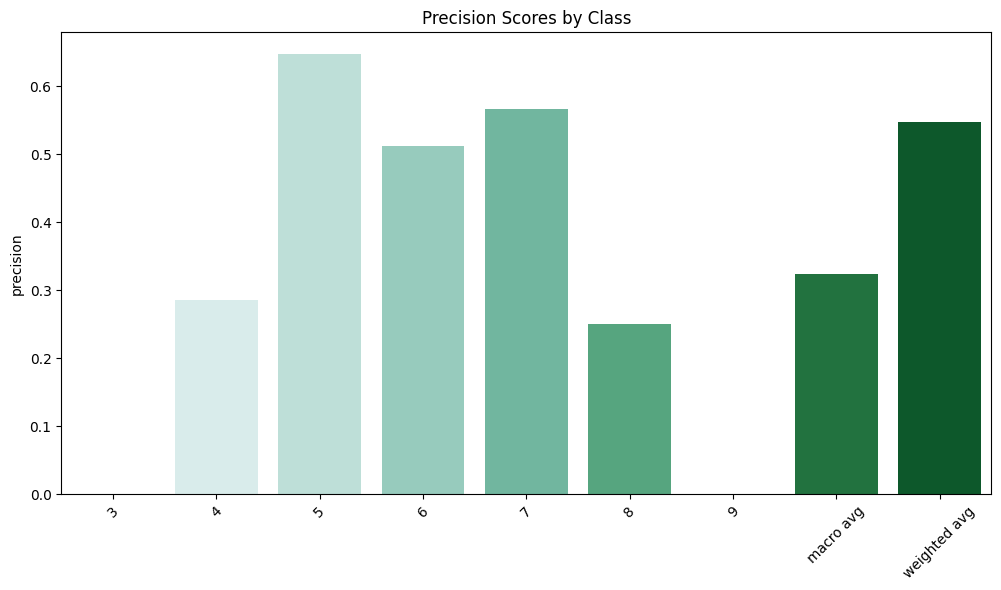

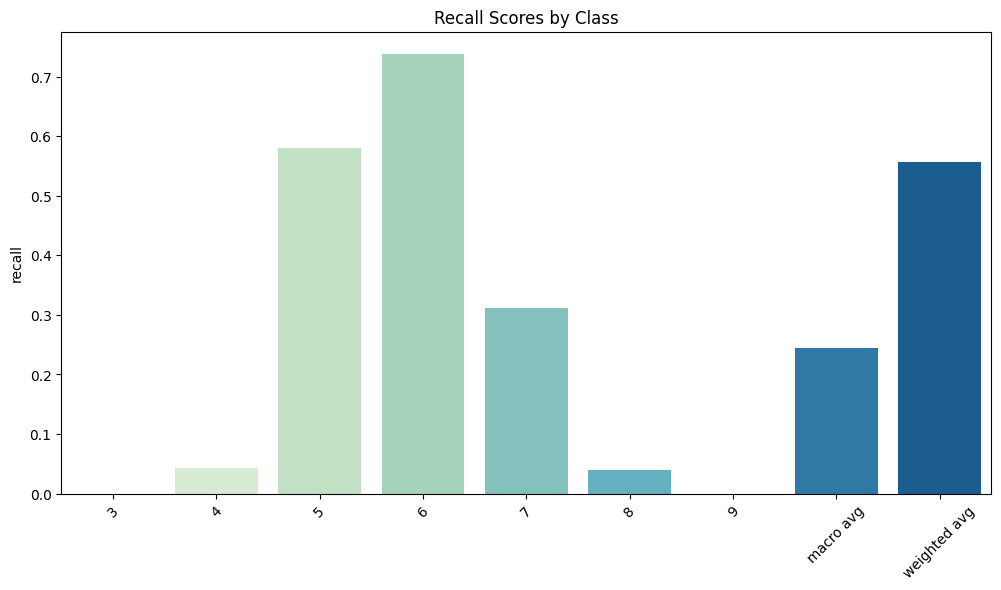

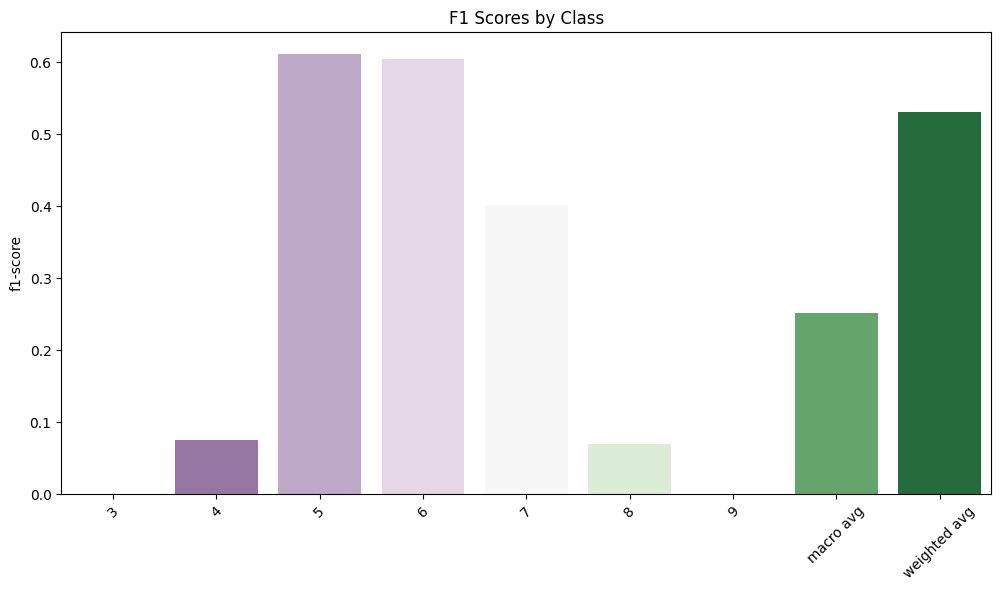

In [12]:
conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_mat, annot=True, fmt='g', cmap='Greens')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()

report_df.drop(['accuracy'], inplace=True)
report_df['support'] = report_df['support'].apply(int)


plt.figure(figsize=(12, 6))
sns.barplot(data=report_df, x=report_df.index, y='precision', palette='BuGn')
plt.title('Precision Scores by Class')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(data=report_df, x=report_df.index, y='recall', palette='GnBu')
plt.title('Recall Scores by Class')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(data=report_df, x=report_df.index, y='f1-score', palette='PRGn')
plt.title('F1 Scores by Class')
plt.xticks(rotation=45)
plt.show()

### Oversampled Random Forest Classifier
Given the imbalanced nature of our dataset, we decided to apply the ADASYN technique for oversampling. This helps in balancing the dataset, improving the performance of our models on minority classes. ADASYN can generate new data samples by considering the existing data points. Neighbors were set to 2 since the class score 9 only has 5 samples in the dataset.

In [13]:
! pip install imblearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.6/235.6 kB 14.8 MB/s eta 0:00:00


In [14]:
from imblearn.over_sampling import ADASYN

adasyn = ADASYN(n_neighbors = 2)
y = pd.concat([y_train, y_test], axis=0, ignore_index=True)
X = pd.concat([X_train, X_test], axis=0, ignore_index=True)
# Applying ADASYN to generate the new dataset
X_adasyn, y_adasyn = adasyn.fit_resample(X, y)

X_train_adasyn, X_test_adasyn, y_train_adasyn, y_test_adasyn = train_test_split(X_adasyn, y_adasyn, test_size=0.2, random_state=42)

In [15]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
}

classifier = RandomForestClassifier(random_state=42, class_weight='balanced')
grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train_adasyn, y_train_adasyn)
best_params = grid_search.best_params_
print(best_params)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   3.0s


[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   2.6s


[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   2.7s


[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   2.7s


[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   2.7s


[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=   5.5s


[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=   5.5s


[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=   5.5s


[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=   5.4s


[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=   5.3s


[CV] END max_depth=None, min_samples_split=2, n_estimators=300; total time=   8.0s


[CV] END max_depth=None, min_samples_split=2, n_estimators=300; total time=   7.9s


[CV] END max_depth=None, min_samples_split=2, n_estimators=300; total time=   8.0s


[CV] END max_depth=None, min_samples_split=2, n_estimators=300; total time=   8.3s


[CV] END max_depth=None, min_samples_split=2, n_estimators=300; total time=   8.1s


[CV] END max_depth=None, min_samples_split=5, n_estimators=100; total time=   2.6s


[CV] END max_depth=None, min_samples_split=5, n_estimators=100; total time=   2.6s


[CV] END max_depth=None, min_samples_split=5, n_estimators=100; total time=   2.6s


[CV] END max_depth=None, min_samples_split=5, n_estimators=100; total time=   2.7s


[CV] END max_depth=None, min_samples_split=5, n_estimators=100; total time=   2.6s


[CV] END max_depth=None, min_samples_split=5, n_estimators=200; total time=   5.2s


[CV] END max_depth=None, min_samples_split=5, n_estimators=200; total time=   5.3s


[CV] END max_depth=None, min_samples_split=5, n_estimators=200; total time=   5.1s


[CV] END max_depth=None, min_samples_split=5, n_estimators=200; total time=   5.2s


[CV] END max_depth=None, min_samples_split=5, n_estimators=200; total time=   5.2s


[CV] END max_depth=None, min_samples_split=5, n_estimators=300; total time=   8.0s


[CV] END max_depth=None, min_samples_split=5, n_estimators=300; total time=   8.5s


[CV] END max_depth=None, min_samples_split=5, n_estimators=300; total time=   7.9s


[CV] END max_depth=None, min_samples_split=5, n_estimators=300; total time=   7.8s


[CV] END max_depth=None, min_samples_split=5, n_estimators=300; total time=   8.1s


[CV] END max_depth=None, min_samples_split=10, n_estimators=100; total time=   2.5s


[CV] END max_depth=None, min_samples_split=10, n_estimators=100; total time=   2.6s


[CV] END max_depth=None, min_samples_split=10, n_estimators=100; total time=   2.7s


[CV] END max_depth=None, min_samples_split=10, n_estimators=100; total time=   2.6s


[CV] END max_depth=None, min_samples_split=10, n_estimators=100; total time=   2.6s


[CV] END max_depth=None, min_samples_split=10, n_estimators=200; total time=   5.1s


[CV] END max_depth=None, min_samples_split=10, n_estimators=200; total time=   5.0s


[CV] END max_depth=None, min_samples_split=10, n_estimators=200; total time=   5.1s


[CV] END max_depth=None, min_samples_split=10, n_estimators=200; total time=   5.1s


[CV] END max_depth=None, min_samples_split=10, n_estimators=200; total time=   5.1s


[CV] END max_depth=None, min_samples_split=10, n_estimators=300; total time=   7.8s


[CV] END max_depth=None, min_samples_split=10, n_estimators=300; total time=   7.5s


[CV] END max_depth=None, min_samples_split=10, n_estimators=300; total time=   7.7s


[CV] END max_depth=None, min_samples_split=10, n_estimators=300; total time=   7.6s


[CV] END max_depth=None, min_samples_split=10, n_estimators=300; total time=   7.7s


[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   2.0s


[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   2.1s


[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   2.0s


[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   2.0s


[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   2.1s


[CV] END max_depth=10, min_samples_split=2, n_estimators=200; total time=   4.1s


[CV] END max_depth=10, min_samples_split=2, n_estimators=200; total time=   4.2s


[CV] END max_depth=10, min_samples_split=2, n_estimators=200; total time=   4.1s


[CV] END max_depth=10, min_samples_split=2, n_estimators=200; total time=   4.0s


[CV] END max_depth=10, min_samples_split=2, n_estimators=200; total time=   4.1s


[CV] END max_depth=10, min_samples_split=2, n_estimators=300; total time=   6.2s


[CV] END max_depth=10, min_samples_split=2, n_estimators=300; total time=   6.1s


[CV] END max_depth=10, min_samples_split=2, n_estimators=300; total time=   6.2s


[CV] END max_depth=10, min_samples_split=2, n_estimators=300; total time=   6.1s


[CV] END max_depth=10, min_samples_split=2, n_estimators=300; total time=   6.1s


[CV] END max_depth=10, min_samples_split=5, n_estimators=100; total time=   2.1s


[CV] END max_depth=10, min_samples_split=5, n_estimators=100; total time=   2.1s


[CV] END max_depth=10, min_samples_split=5, n_estimators=100; total time=   2.0s


[CV] END max_depth=10, min_samples_split=5, n_estimators=100; total time=   2.1s


[CV] END max_depth=10, min_samples_split=5, n_estimators=100; total time=   2.0s


[CV] END max_depth=10, min_samples_split=5, n_estimators=200; total time=   4.1s


[CV] END max_depth=10, min_samples_split=5, n_estimators=200; total time=   4.0s


[CV] END max_depth=10, min_samples_split=5, n_estimators=200; total time=   4.1s


[CV] END max_depth=10, min_samples_split=5, n_estimators=200; total time=   4.1s


[CV] END max_depth=10, min_samples_split=5, n_estimators=200; total time=   4.0s


[CV] END max_depth=10, min_samples_split=5, n_estimators=300; total time=   6.1s


[CV] END max_depth=10, min_samples_split=5, n_estimators=300; total time=   6.1s


[CV] END max_depth=10, min_samples_split=5, n_estimators=300; total time=   6.0s


[CV] END max_depth=10, min_samples_split=5, n_estimators=300; total time=   5.9s


[CV] END max_depth=10, min_samples_split=5, n_estimators=300; total time=   5.9s


[CV] END max_depth=10, min_samples_split=10, n_estimators=100; total time=   2.0s


[CV] END max_depth=10, min_samples_split=10, n_estimators=100; total time=   2.1s


[CV] END max_depth=10, min_samples_split=10, n_estimators=100; total time=   2.0s


[CV] END max_depth=10, min_samples_split=10, n_estimators=100; total time=   2.1s


[CV] END max_depth=10, min_samples_split=10, n_estimators=100; total time=   2.1s


[CV] END max_depth=10, min_samples_split=10, n_estimators=200; total time=   4.2s


[CV] END max_depth=10, min_samples_split=10, n_estimators=200; total time=   4.1s


[CV] END max_depth=10, min_samples_split=10, n_estimators=200; total time=   4.0s


[CV] END max_depth=10, min_samples_split=10, n_estimators=200; total time=   4.0s


[CV] END max_depth=10, min_samples_split=10, n_estimators=200; total time=   4.1s


[CV] END max_depth=10, min_samples_split=10, n_estimators=300; total time=   6.2s


[CV] END max_depth=10, min_samples_split=10, n_estimators=300; total time=   6.3s


[CV] END max_depth=10, min_samples_split=10, n_estimators=300; total time=   6.2s


[CV] END max_depth=10, min_samples_split=10, n_estimators=300; total time=   6.1s


[CV] END max_depth=10, min_samples_split=10, n_estimators=300; total time=   6.0s


[CV] END max_depth=20, min_samples_split=2, n_estimators=100; total time=   2.7s


[CV] END max_depth=20, min_samples_split=2, n_estimators=100; total time=   2.8s


[CV] END max_depth=20, min_samples_split=2, n_estimators=100; total time=   2.6s


[CV] END max_depth=20, min_samples_split=2, n_estimators=100; total time=   2.7s


[CV] END max_depth=20, min_samples_split=2, n_estimators=100; total time=   2.7s


[CV] END max_depth=20, min_samples_split=2, n_estimators=200; total time=   5.5s


[CV] END max_depth=20, min_samples_split=2, n_estimators=200; total time=   5.4s


[CV] END max_depth=20, min_samples_split=2, n_estimators=200; total time=   5.4s


[CV] END max_depth=20, min_samples_split=2, n_estimators=200; total time=   5.4s


[CV] END max_depth=20, min_samples_split=2, n_estimators=200; total time=   5.3s


[CV] END max_depth=20, min_samples_split=2, n_estimators=300; total time=   8.1s


[CV] END max_depth=20, min_samples_split=2, n_estimators=300; total time=   7.9s


[CV] END max_depth=20, min_samples_split=2, n_estimators=300; total time=   8.0s


[CV] END max_depth=20, min_samples_split=2, n_estimators=300; total time=   8.0s


[CV] END max_depth=20, min_samples_split=2, n_estimators=300; total time=   8.0s


[CV] END max_depth=20, min_samples_split=5, n_estimators=100; total time=   2.7s


[CV] END max_depth=20, min_samples_split=5, n_estimators=100; total time=   2.6s


[CV] END max_depth=20, min_samples_split=5, n_estimators=100; total time=   2.6s


[CV] END max_depth=20, min_samples_split=5, n_estimators=100; total time=   2.6s


[CV] END max_depth=20, min_samples_split=5, n_estimators=100; total time=   2.6s


[CV] END max_depth=20, min_samples_split=5, n_estimators=200; total time=   5.3s


[CV] END max_depth=20, min_samples_split=5, n_estimators=200; total time=   5.2s


[CV] END max_depth=20, min_samples_split=5, n_estimators=200; total time=   5.3s


[CV] END max_depth=20, min_samples_split=5, n_estimators=200; total time=   5.2s


[CV] END max_depth=20, min_samples_split=5, n_estimators=200; total time=   5.2s


[CV] END max_depth=20, min_samples_split=5, n_estimators=300; total time=   7.7s


[CV] END max_depth=20, min_samples_split=5, n_estimators=300; total time=   7.8s


[CV] END max_depth=20, min_samples_split=10, n_estimators=100; total time=   2.5s


[CV] END max_depth=20, min_samples_split=10, n_estimators=100; total time=   2.5s


[CV] END max_depth=20, min_samples_split=10, n_estimators=100; total time=   2.5s


[CV] END max_depth=20, min_samples_split=10, n_estimators=100; total time=   2.5s


[CV] END max_depth=20, min_samples_split=10, n_estimators=100; total time=   2.5s


[CV] END max_depth=20, min_samples_split=10, n_estimators=200; total time=   5.1s


[CV] END max_depth=20, min_samples_split=10, n_estimators=200; total time=   4.9s


[CV] END max_depth=20, min_samples_split=10, n_estimators=200; total time=   5.1s


[CV] END max_depth=20, min_samples_split=10, n_estimators=200; total time=   5.0s


[CV] END max_depth=20, min_samples_split=10, n_estimators=200; total time=   5.0s


[CV] END max_depth=20, min_samples_split=10, n_estimators=300; total time=   7.6s


[CV] END max_depth=20, min_samples_split=10, n_estimators=300; total time=   7.5s


[CV] END max_depth=20, min_samples_split=10, n_estimators=300; total time=   7.7s


[CV] END max_depth=20, min_samples_split=10, n_estimators=300; total time=   7.6s


[CV] END max_depth=20, min_samples_split=10, n_estimators=300; total time=   7.5s


[CV] END max_depth=30, min_samples_split=2, n_estimators=100; total time=   2.7s


[CV] END max_depth=30, min_samples_split=2, n_estimators=100; total time=   2.7s


[CV] END max_depth=30, min_samples_split=2, n_estimators=100; total time=   2.7s


[CV] END max_depth=30, min_samples_split=2, n_estimators=100; total time=   2.8s


[CV] END max_depth=30, min_samples_split=2, n_estimators=100; total time=   3.0s


[CV] END max_depth=30, min_samples_split=2, n_estimators=200; total time=   5.9s


[CV] END max_depth=30, min_samples_split=2, n_estimators=200; total time=   5.8s


[CV] END max_depth=30, min_samples_split=2, n_estimators=200; total time=   5.6s


[CV] END max_depth=30, min_samples_split=2, n_estimators=200; total time=   5.3s


[CV] END max_depth=30, min_samples_split=2, n_estimators=200; total time=   5.3s


[CV] END max_depth=30, min_samples_split=2, n_estimators=300; total time=   8.1s


[CV] END max_depth=30, min_samples_split=2, n_estimators=300; total time=   8.0s


[CV] END max_depth=30, min_samples_split=2, n_estimators=300; total time=   8.0s


[CV] END max_depth=30, min_samples_split=2, n_estimators=300; total time=   8.1s


[CV] END max_depth=30, min_samples_split=2, n_estimators=300; total time=   8.1s


[CV] END max_depth=30, min_samples_split=5, n_estimators=100; total time=   2.7s


[CV] END max_depth=30, min_samples_split=5, n_estimators=100; total time=   2.6s


[CV] END max_depth=30, min_samples_split=5, n_estimators=100; total time=   2.6s


[CV] END max_depth=30, min_samples_split=5, n_estimators=100; total time=   2.6s


[CV] END max_depth=30, min_samples_split=5, n_estimators=100; total time=   2.6s


[CV] END max_depth=30, min_samples_split=5, n_estimators=200; total time=   5.2s


[CV] END max_depth=30, min_samples_split=5, n_estimators=200; total time=   5.1s


[CV] END max_depth=30, min_samples_split=5, n_estimators=200; total time=   5.1s


[CV] END max_depth=30, min_samples_split=5, n_estimators=200; total time=   5.2s


[CV] END max_depth=30, min_samples_split=5, n_estimators=200; total time=   5.1s


[CV] END max_depth=30, min_samples_split=5, n_estimators=300; total time=   7.9s


[CV] END max_depth=30, min_samples_split=5, n_estimators=300; total time=   8.0s


[CV] END max_depth=30, min_samples_split=5, n_estimators=300; total time=   7.7s


[CV] END max_depth=30, min_samples_split=5, n_estimators=300; total time=   7.8s


[CV] END max_depth=30, min_samples_split=5, n_estimators=300; total time=   7.9s


[CV] END max_depth=30, min_samples_split=10, n_estimators=100; total time=   2.5s


[CV] END max_depth=30, min_samples_split=10, n_estimators=100; total time=   2.6s


[CV] END max_depth=30, min_samples_split=10, n_estimators=100; total time=   2.5s


[CV] END max_depth=30, min_samples_split=10, n_estimators=100; total time=   2.6s


[CV] END max_depth=30, min_samples_split=10, n_estimators=100; total time=   2.5s


[CV] END max_depth=30, min_samples_split=10, n_estimators=200; total time=   5.2s


[CV] END max_depth=30, min_samples_split=10, n_estimators=200; total time=   5.2s


[CV] END max_depth=30, min_samples_split=10, n_estimators=200; total time=   5.2s


[CV] END max_depth=30, min_samples_split=10, n_estimators=200; total time=   5.0s


[CV] END max_depth=30, min_samples_split=10, n_estimators=200; total time=   5.2s


[CV] END max_depth=30, min_samples_split=10, n_estimators=300; total time=   7.7s


[CV] END max_depth=30, min_samples_split=10, n_estimators=300; total time=   7.6s


[CV] END max_depth=30, min_samples_split=10, n_estimators=300; total time=   7.8s


[CV] END max_depth=30, min_samples_split=10, n_estimators=300; total time=   7.6s


[CV] END max_depth=30, min_samples_split=10, n_estimators=300; total time=   7.8s


{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300}


In [16]:
brf_classifier = RandomForestClassifier(class_weight='balanced', random_state=42,n_estimators=300, max_depth=None, min_samples_leaf=1, min_samples_split=2)
brf_classifier.fit(X_train_adasyn, y_train_adasyn)

y_pred_brf = brf_classifier.predict(X_test_adasyn)

accuracy_brf = accuracy_score(y_test_adasyn, y_pred_brf)
classification_rep_brf = classification_report(y_test_adasyn, y_pred_brf)

(accuracy_brf, classification_rep_brf)

(0.8535150201300712,
 '              precision    recall  f1-score   support\n\n           3       0.98      1.00      0.99       452\n           4       0.89      0.99      0.94       509\n           5       0.74      0.73      0.73       493\n           6       0.61      0.48      0.54       452\n           7       0.78      0.79      0.78       428\n           8       0.91      0.99      0.95       446\n           9       1.00      1.00      1.00       449\n\n    accuracy                           0.85      3229\n   macro avg       0.84      0.85      0.85      3229\nweighted avg       0.84      0.85      0.85      3229\n')

As we can see, the performance is largely improved by the oversampling, allowing the model to reach high precision and recall scores on the minority classes.

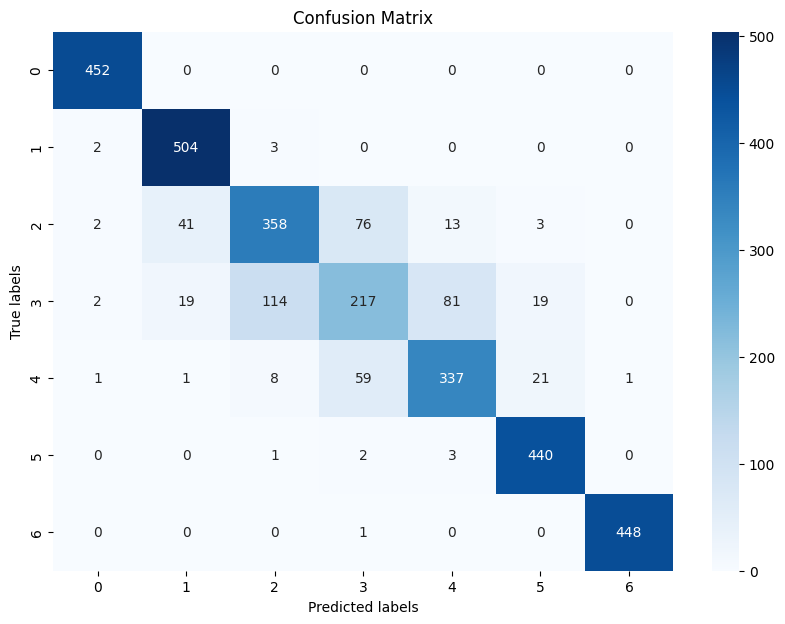

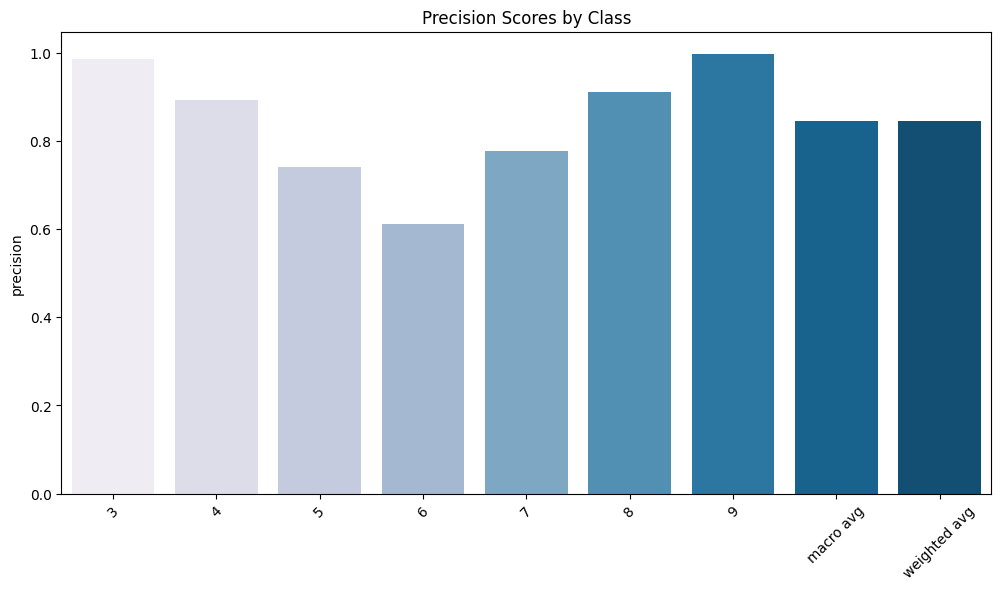

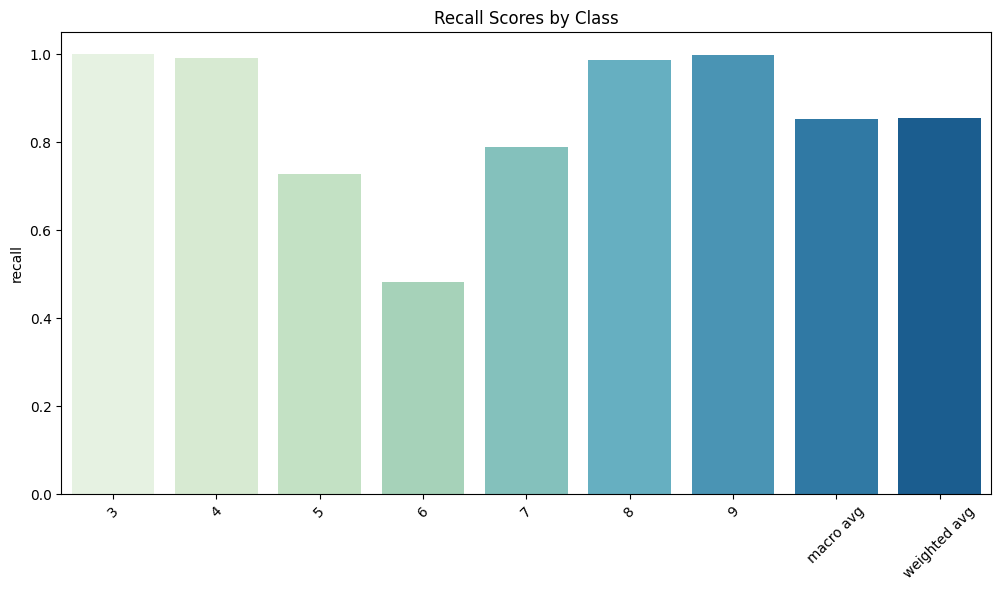

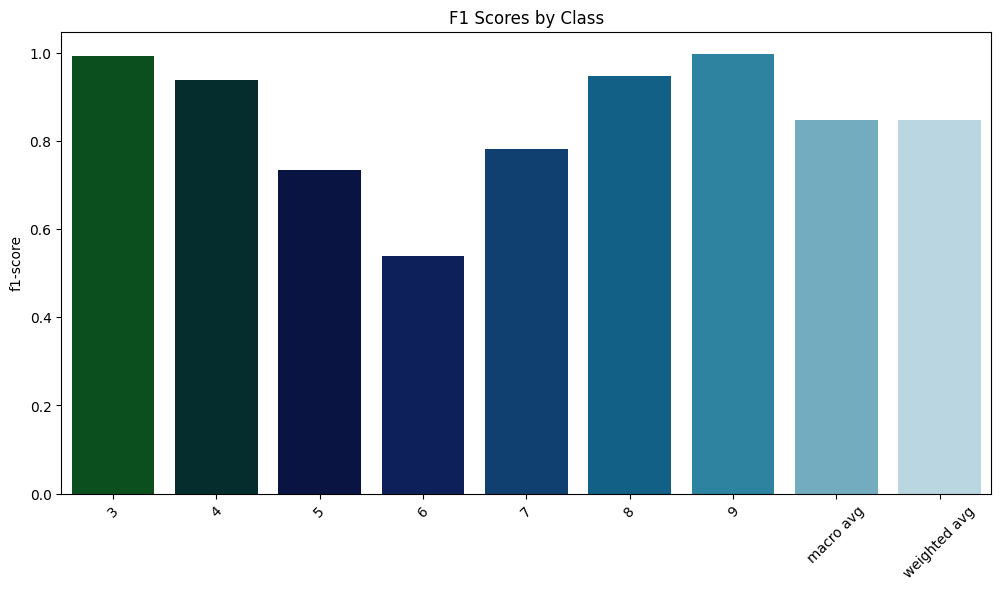

In [17]:
conf_mat = confusion_matrix(y_test_adasyn, y_pred_brf)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_mat, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

report = classification_report(y_test_adasyn, y_pred_brf, output_dict=True)
report_df = pd.DataFrame(report).transpose()

report_df.drop(['accuracy'], inplace=True)
report_df['support'] = report_df['support'].apply(int)

# Plotting Precision, Recall, and F1-Score
plt.figure(figsize=(12, 6))
sns.barplot(data=report_df, x=report_df.index, y='precision', palette='PuBu')
plt.title('Precision Scores by Class')
plt.xticks(rotation=45)
plt.show()
plt.figure(figsize=(12, 6))
sns.barplot(data=report_df, x=report_df.index, y='recall', palette='GnBu')
plt.title('Recall Scores by Class')
plt.xticks(rotation=45)
plt.show()
plt.figure(figsize=(12, 6))
sns.barplot(data=report_df, x=report_df.index, y='f1-score', palette='ocean')
plt.title('F1 Scores by Class')
plt.xticks(rotation=45)
plt.show()

In [18]:
mr = project.get_model_registry()

# The contents of the 'wine_model_2' directory will be saved to the model registry. Create the dir, first.
model_dir="wine_model_upsampled"
if os.path.isdir(model_dir) == False:
    os.mkdir(model_dir)

# Save both our model and the confusion matrix to 'model_dir', whose contents will be uploaded to the model registry
joblib.dump(brf_classifier, model_dir + "/wine_model_upsampled.pkl")
fig.savefig(model_dir + "/confusion_matrix_upsampled.png")

# Specify the schema of the model's input/output using the features (X_train) and labels (y_train)
input_schema = Schema(X_train)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema, output_schema)

# Create an entry in the model registry that includes the model's name, desc, metrics
wine_model = mr.python.create_model(
    name="wine_model_upsampled",
    metrics={"accuracy" : accuracy_brf},
    model_schema=model_schema,
    description="Wine Quality Predictor Updated"
)

# Upload the model to the model registry, including all files in 'model_dir'
wine_model.save(model_dir)

Connected. Call `.close()` to terminate connection gracefully.


  0%|          | 0/6 [00:00<?, ?it/s]

Model created, explore it at https://35.204.254.42/p/119/models/wine_model_upsampled/1


Model(name: 'wine_model_upsampled', version: 1)